# Parsing multiple KinExA activity logs.
The KinExA software can export an analysis file for a completed experiment (as a TSV file).  This code will read a folder with many such files and extract useful data from them, for display and future work.

In [577]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib as mpl

# We'll make sure to display the full dataframe, so we're not confused about its nature and contents.
pd.set_option('display.expand_frame_repr', False)
pd.set_option("display.max_rows", None)

First, declare the folder that contains the TSV files to be parsed.

In [578]:
path = "/Users/DanielMA/Root/Hinge/Data analysis/Test data"
allFiles = glob.glob(os.path.join(path,"*.tsv"))

The dataframe all_the_data that contains all the information from all the parsed files.

In [579]:
all_the_data = pd.DataFrame()
list_ = []
file_index = 0
for file_ in allFiles:    
    df = pd.read_csv(file_,index_col=None, header=0, sep='\t')
    
    # I also added a new column to each entry that contains the filename.
    short_name = file_.replace(path+'/','')
    short_name = short_name.replace('.tsv','')
    df['File Name'] = short_name
    
    # And a new column that contains a second index to indicate which experiment it is.
    df['File Index'] = file_index
    file_index = file_index + 1
    
    list_.append(df)
    
all_the_data = pd.concat(list_)

The first useful output is a summary Excel file with all the relevant info and nothing else.

In [583]:
results = all_the_data.loc[0,['File Index','File Name','Experiment Name','Kd','Kd High', 'Kd Low','%Error','Ratio','CBP %Activity','Sig100','NSB','Analysis Type','Comments']]
results = results.set_index('File Index')

writer = pd.ExcelWriter('/Users/DanielMA/Root/Hinge/Data analysis/Test data/Table.xlsx')
results.to_excel(writer,'Sheet1')
writer.save()

The second is a horizontal bar plot of the Kd ranges calculated for each experiment.

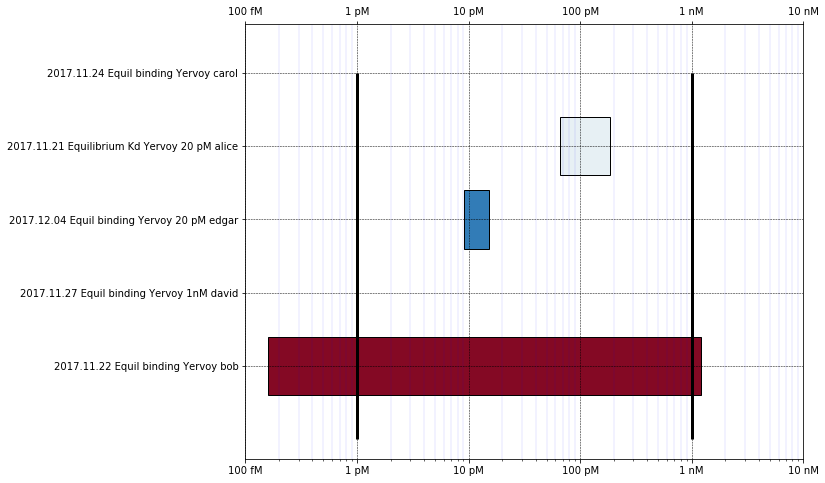

In [584]:
plt.clf

# The parameters for the bars are extracted from the same Results dataframe that we exported to Excel.
labels = results.loc[:,'File Name'].values.tolist()
kd = results.loc[:,'Kd']
kd_hi = results.loc[:,'Kd High']
kd_lo = results.loc[:,'Kd Low']
bar_height = kd_hi - kd_lo
ind = np.arange(len(results))

# The color scheme ranges from blue (low error) to red (high error), with the scale centered at 3.0 (white).
cmap = mpl.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=1, vmax=5)  #Extreme values beyond this take the full red or blue color.
color_final = cmx.ScalarMappable(norm=norm, cmap=cmap).to_rgba(results.loc[:,'%Error'])


fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(ind, bar_height,left=kd_lo, align='center', color=color_final, edgecolor='k', linewidth=1)

# ax.set_xlabel('Kd')
# ax.set_title('Kd ranges for all these experiments')
ax.set_xlim(1e-13,1e-8)
ax.set_xscale('log')
ax.vlines(1e-9,0,len(results), linewidth=3)  #Vertical line at 1 nM
ax.vlines(1e-12,0,len(results), linewidth=3)  #Vertical line at 1 pM
ax.grid(which="major", axis='both', color='k', linestyle='--', linewidth=0.5)
ax.grid(which="minor", axis='both', color='b', linestyle='-', linewidth=0.1)
ax.tick_params(top=True, labeltop=True)


plt.xticks([1e-13,1e-12,1e-11,1e-10,1e-9,1e-8],['100 fM','1 pM','10 pM','100 pM','1 nM','10 nM'])
plt.yticks(ind, labels)

plt.gca().invert_yaxis()
plt.savefig('/Users/DanielMA/Root/Hinge/Data analysis/Test data/Graph.png',bbox_inches='tight')
plt.show()


In [582]:
# list(all_the_data) # Displays all the column names, so we know what to copy.
# results # Displayed so we can see what is in the vector.